## Cancer Classification from Gene Expression

The purpose of this project is to build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements.

Each row in this dataset corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

I will be using Principal Components Analysis (PCA) to visualize the data and reduce its dimensions. I will also be using linear and logistic regression to build the classification model for this dataset.

<hr style="height:2pt">

In [13]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

### Data Exploration and Pre-Processing

In [46]:
df = pd.read_csv('cancer_df.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [47]:
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
3,0,-72,-144,238,55,-399,-551,131,-179,126,...,30,819,-178,151,-18,1140,482,10,369,-42
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
7,0,-107,-72,-126,149,-205,-284,-166,-185,1,...,120,722,20,332,-5,195,59,31,116,-18
8,0,-117,-219,-50,257,-218,-402,228,-147,65,...,79,631,-26,455,-62,736,445,42,247,-43


Upon observing the dataframe, I noticed that there appears to be severe differences in the measurements from one gene to the next (some are negative, while others are around zero and some into the thousands). In order to account for these vast differences in scale and variability, I will be normalizing each predictor to vary between 0 and 1. 

In order to normalize the data, I will be using the following equation:
$$x_i^{\prime} = \frac{x_i - \min{x}}{\max{x} - \min{x}}.$$


In [48]:
# creating a function to normalize all columns in the dataframe
def normalize_columns(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

X_min = np.min(data_train,axis=0)
X_max = np.max(data_train,axis=0)

data_train = normalize_columns(X=data_train, X_min=X_min, X_max=X_max)
data_test = normalize_columns(X=data_test, X_min=X_min, X_max=X_max)   

assert np.max(data_train.values)==1 and np.min(data_train.values)==0    

In [49]:
# Checking to see if the data values lie between 0 and 1
data_train.describe()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,0.351351,0.737990,0.738965,0.367833,0.393290,0.446655,0.569688,0.672930,0.616530,0.589797,...,0.446380,0.465920,0.538981,0.191599,0.660160,0.333819,0.285570,0.659308,0.146967,0.668155
std,0.483978,0.191568,0.184832,0.244597,0.257859,0.208153,0.250852,0.200634,0.204078,0.230322,...,0.201848,0.254305,0.235105,0.175682,0.210450,0.214713,0.194345,0.169714,0.185908,0.186360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.669439,0.654440,0.172708,0.155172,0.329508,0.343066,0.598490,0.555814,0.400000,...,0.344754,0.287409,0.423077,0.111055,0.551852,0.208178,0.134783,0.614907,0.071097,0.595652
50%,0.000000,0.767152,0.762548,0.360341,0.374384,0.500000,0.571168,0.687714,0.669767,0.587500,...,0.408994,0.461679,0.567308,0.139073,0.677778,0.310409,0.266087,0.667702,0.100850,0.682609
75%,1.000000,0.866944,0.857143,0.469083,0.571429,0.573770,0.771898,0.802334,0.730233,0.782500,...,0.563169,0.574818,0.695513,0.211921,0.800000,0.405824,0.371304,0.739130,0.136012,0.773913
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
data_train.shape

(37, 7130)

Looking at the shape of the dataset the number of predictor variables greatly exceeds the number of observations in the data frame. With many more predictors than observations, the model is grossly underidentified/underdetermined. In such a sitution we could risk finding spurious relationships between predictors and response.

### Exploring how the genes `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at` discriminate between cancer classes

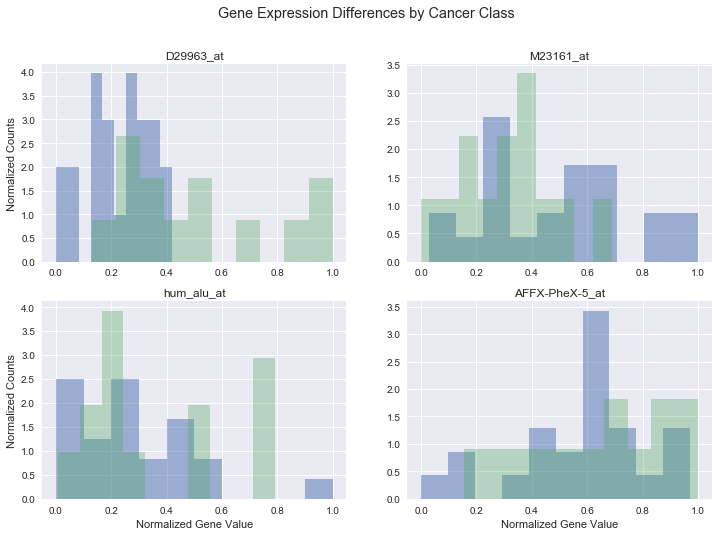

In [51]:
top_alpha = 0.35

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

fig.suptitle("Gene Expression Differences by Cancer Class")

ax[0,0].hist(data_train[data_train.Cancer_type == 0]['D29963_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[0,0].hist(data_train[data_train.Cancer_type == 1]['D29963_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[0,0].set_ylabel('Normalized Counts')
ax[0,0].set_title('D29963_at')

ax[0,1].hist(data_train[data_train.Cancer_type == 0]['M23161_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[0,1].hist(data_train[data_train.Cancer_type == 1]['M23161_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[0,1].set_title('M23161_at')

ax[1,0].hist(data_train[data_train.Cancer_type == 0]['hum_alu_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[1,0].hist(data_train[data_train.Cancer_type == 1]['hum_alu_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[1,0].set_title('hum_alu_at')
ax[1,0].set_xlabel('Normalized Gene Value')
ax[1,0].set_ylabel('Normalized Counts')

ax[1,1].hist(data_train[data_train.Cancer_type == 0]['AFFX-PheX-5_at'], 
           label="Cancer Type = 0", density=True,
           alpha=alpha)

ax[1,1].hist(data_train[data_train.Cancer_type == 1]['AFFX-PheX-5_at'], 
           label="Cancer Type = 1", density=True,
           alpha=top_alpha)

ax[1,1].set_title('AFFX-PheX-5_at')
ax[1,1].set_xlabel('Normalized Gene Value');

The distributions of gene expression for this subset look very similar across cancer types. `D29963_at` seems the most promising of the bunch.

### Using PCA to visualize the data

The first two principal components explain 0.276 of the variance.


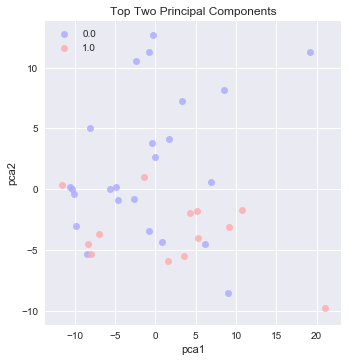

In [52]:
# split out target variable
X_train = data_train.iloc[:,1:]
y_train = data_train.iloc[:,0]
X_test = data_test.iloc[:,1:]
y_test = data_test.iloc[:,0]

# pca
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print("The first two principal components explain %0.3f of the variance."
      % np.sum(pca.explained_variance_ratio_))

# scatter plot
X_train_pca_df = pd.DataFrame(X_train_pca, columns=["pca1", "pca2"])
X_train_pca_df["Cancer_type"] = y_train.values
sns.lmplot(x="pca1", 
           y="pca2", 
           hue="Cancer_type", 
           data=X_train_pca_df,
           fit_reg=False, 
           legend=False, 
           palette='bwr')
plt.title('Top Two Principal Components')
plt.legend();

It's difficult to draw a decision boundary (even a non-linear one) that perfectly separates red from blue points. However, there’s clearly some useful info in these two components in terms of creating a classifier.

#### Exploring the fit of Linear Regression vs Logistic Regression in Building the Classification Model

Using the single gene predictor `D29963_at` I will be fitting a simple **linear regression model** to the training set. 

In [53]:
# add column to house intercept
X_train_wcons = sm.add_constant(X_train[["D29963_at"]])
X_test_wcons = sm.add_constant(X_test[["D29963_at"]])

# fit
ols = OLS(endog=y_train, exog=X_train_wcons).fit()

Converting the fitted linear regression model to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. 

In [54]:
# predictions
y_hat_ols_train = ols.predict(X_train_wcons)
y_hat_ols_test = ols.predict(X_test_wcons)

# accuracy
print("OLS single predictor accuracy in train = %0.3f" 
      % accuracy_score(y_train, y_hat_ols_train>0.5))

print("OLS single predictor accuracy in test = %0.3f" 
      % accuracy_score(y_test, y_hat_ols_test>0.5))

OLS single predictor accuracy in train = 0.811
OLS single predictor accuracy in test = 0.778


Next, I will be fitting a simple **logistic regression model** to the training set. 

In [55]:
logreg = LogisticRegression(C=100000, fit_intercept=False)
logreg.fit(X_train_wcons, y_train);

In [56]:
y_hat_logreg_train = logreg.predict_proba(X_train_wcons)[:,1]
y_hat_logreg_test = logreg.predict_proba(X_test_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logreg_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logreg_test>0.5))

Training Accuracy: 0.811
Test Accuracy: 0.750


* Logistic regression yields the same test accuracy as the linear regression model.


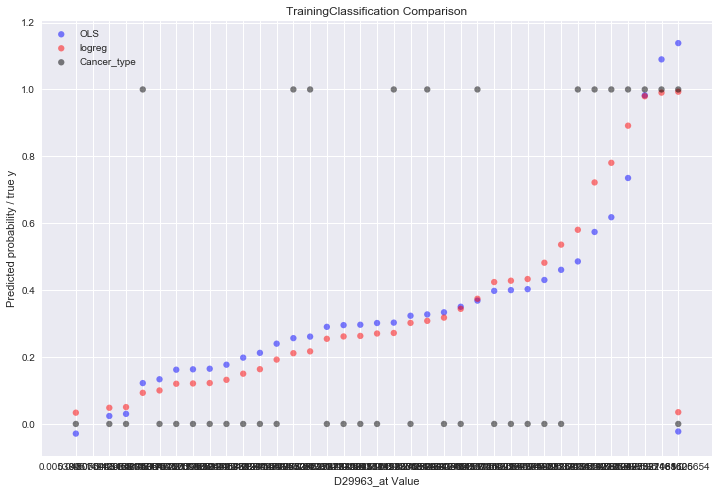

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.suptitle("")

ax.scatter(X_train[["D29963_at"]], 
           y_hat_ols_train, 
           label="OLS", 
           c='blue', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.scatter(X_train[["D29963_at"]], 
           y_hat_logreg_train, 
           label="logreg", 
           c='red', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.scatter(X_train[["D29963_at"]], 
           y_train, 
           label="Cancer_type", 
           c='black', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax.legend(loc='best');
ax.set_xlabel('D29963_at Value')
ax.set_ylabel('Predicted probability / true y')
ax.set_title('TrainingClassification Comparison');

* Both OLS and Logistic Regression appear to yield similar predicted values. 
* Based on this figure, the Logistic Regression model does appear to be a better fit. Given that Logistic Regression gives us a valid probability, the Logistic Regression model would be preferred over the OLS model.

### Multiple Logistic Regression

In [58]:
logregmul = LogisticRegression(C=100000, fit_intercept=False)

X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)

logregmul.fit(X_train_mul_wcons, y_train);

In [59]:
y_hat_logregmul_train = logregmul.predict_proba(X_train_mul_wcons)[:,1]
y_hat_logregmul_test = logregmul.predict_proba(X_test_mul_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logregmul_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logregmul_test>0.5))

Training Accuracy: 1.000
Test Accuracy: 1.000


* Accuracy in both training and test improves considerably with all genes vs a single gene.

#####  Visualizing the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. 

The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. 

In [60]:
# function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

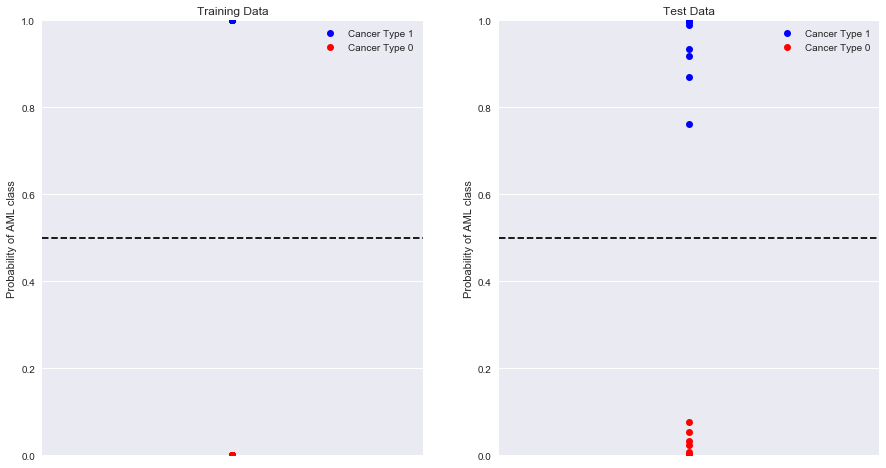

In [61]:
""" Plot classification model """

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

fig.suptitle("")

visualize_prob(logregmul, 
               X_train_mul_wcons, 
               y_train, ax[0])
ax[0].set_title('Training Data')

visualize_prob(logregmul, 
               X_test_mul_wcons, 
               y_test, ax[1])
ax[1].set_title('Test Data');

* In training the probabilities are either 1 or 0. In test probabilities a handful of predicted probabilities fall closer to 0.5. 
* For these points, we are unsure if we should predict $\hat{y}=0$ or $\hat{y}=1$.

##### Analyzing Significance of Coefficients

In [62]:
iterations = 1000

b_genes_boot = np.zeros((X_train_mul_wcons.shape[1],iterations))

for i in range(iterations):
    # sample with replacement from X_train
    boot_rows = np.random.choice(range(X_train_mul_wcons.shape[0]), size=X_train_mul_wcons.shape[0], replace=True)
    X_train_boot = X_train_mul_wcons.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]

    # fit
    logregmul_boot = LogisticRegression(C=100000, fit_intercept=False)
    logregmul_boot.fit(X_train_boot, y_train_boot)
    b_genes_boot[:,i] = logregmul_boot.coef_


In [63]:
# constructing confidence intervals
b_genes_ci_upper = np.percentile(b_genes_boot, 97.5, axis=1)
b_genes_ci_lower = np.percentile(b_genes_boot, 2.5, axis=1)

In [64]:
# significant predictors
sig_b_ct = 0

# if ci contains 0, then insignificant
for i in range(X_train_mul_wcons.shape[1]):
    if b_genes_ci_upper[i]<=0 or b_genes_ci_lower[i]>=0:
        sig_b_ct += 1

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, X_train_mul_wcons.shape[1]))

Significant coefficents at 5pct level = 1843 / 7130


### Using PCA and Dimensionality Reduction

In order to reduce the dimensionality of the data I will be using PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.


In [65]:
pca = PCA()
pca.fit(X_train)
var_c = np.cumsum(pca.explained_variance_ratio_)

n_components_pca = np.sum(var_c<0.9)
print("The first %i components explain %0.3f of variance" % (n_components_pca+1, var_c[n_components_pca]))

X_train_pca = pca.transform(X_train)[:,:n_components_pca]
X_test_pca = pca.transform(X_test)[:,:n_components_pca]

The first 27 components explain 0.907 of variance


In [66]:
logregpca = LogisticRegression(C=100000, fit_intercept=True)
logregpca.fit(X_train_pca, y_train)

y_hat_pca_train = logregpca.predict_proba(X_train_pca)[:,1]
y_hat_pca_test = logregpca.predict_proba(X_test_pca)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_pca_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_pca_test>0.5))

Training Accuracy: 1.000
Test Accuracy: 0.944


* The accuracy in train is identical for pca + logreg vs logreg. The testing accuracy dropped slightly with PCA. 

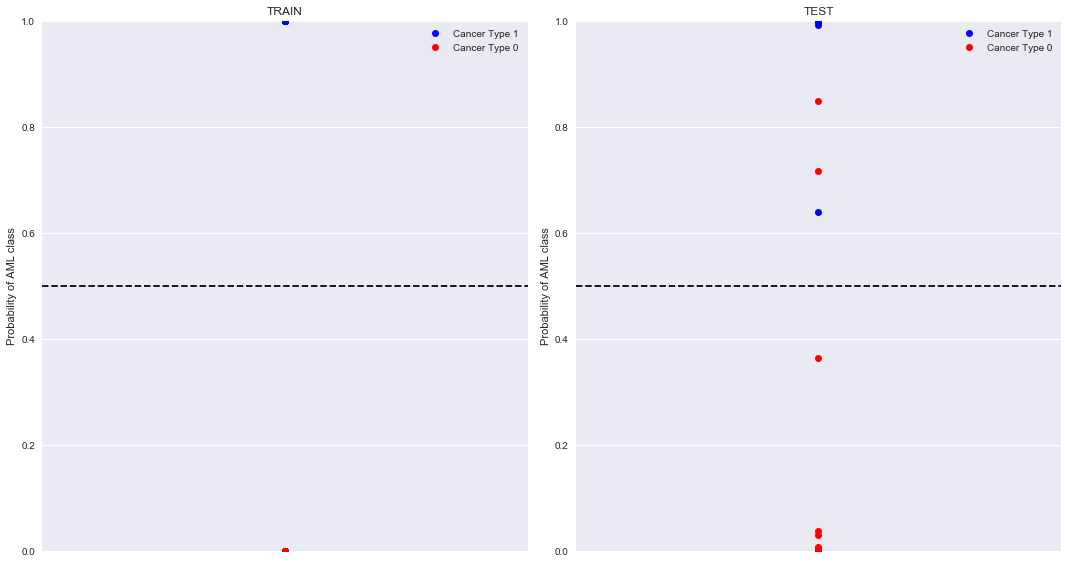

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
visualize_prob(
    model=logregpca,
    x=X_train_pca,
    y=y_train,
    ax=ax1)
ax1.set_title("TRAIN")
visualize_prob(
    model=logregpca,
    x=X_test_pca,
    y=y_test,
    ax=ax2)
ax2.set_title("TEST")
plt.tight_layout()

* With the all-predictor logit model we risk finding spurious relationships between predictors and response.
* Using PCA we hope to find some lower dimensional representation of our predictors that retains our predictive power but hopefully is less vulnerable to overfitting. 
* In training, the pca+logit model is still able to exactly distinguish between ALL and AML. However we see our performance has not improved in test (we have a misclassified point).